# Optimal Inventories

Consider a firm manages its inventory to maximizes firm value.

Assume that there is no exit option.  Hence, the firm value is

$$ V_0 = \mathbb{E} \sum_{t \geq 0} \beta^t \pi_t. $$

Assume that the firm only sells one product. 

Random shock $d \in \mathbb{Z}_+$: the firm faces exogenous demamd process $D_t$ is i.i.d with $\psi$. 

Assume that the firm can store at most $K$ items at one time.

Action $a \in A = \{0, \cdots, K\}$: the units of stock ordered $A_t$.

State $x \in X = \{0, \cdots, K\}$: the inventory of the product $X_t$.

The timing of events:
$$ x_t \to \text{ choose } a_t \to d_{t+1} 
\to x_{t+1} = f(x_t, a_t, d_{t+1}) = (x_t - d_{t+1}) \vee 0 + a_t.$$

Intuition of the transition function $f$: $A_t$ take one period to arrive.
(Discussion later!)

With the firm's product as the numeraire, current profits are given by

$$ \pi_t = X_t \wedge D_{t+1} 
- cA_t - \kappa \mathbb{1}\{A_t > 0\}. $$

Here $c$ is unit product cost and 
$\kappa$ is a fixed cost of ordering inventory.

Hence, the corresponding Bellman equation is

$$ v(x) = \max_{0 \leq a \leq K - x}
\left\{
\sum_{d \geq 0} \left[\pi(x, a, d) + \beta v(f(x, a, d))\right]
\psi(d) \right\}. $$

In [23]:
from quantecon import compute_fixed_point

import numpy as np
from collections import namedtuple
from numba import jit, prange
import matplotlib.pyplot as plt

Assume that $\psi$ is the geometric distribution on $\mathbb{Z}_+$ with
parameter $p$:

$$ Pr(D = d) = (1 - p)^d * p. $$

The stochastic kernel from $G$ to $X$ is

$$
P(x, a, x') = \begin{cases}
0, & x' < a \\
(1-p)^x, & x' = a \\
(1-p)^{x+a-x'} p, & x' > a
\end{cases}. $$

The first case tells us that when $d_{t+1} > x_t$, the transition probability is 0. That is why we can set a upper bound $d_{max} > K$ in coding.

In [10]:
# NamedTuple Model
Model = namedtuple("Model", ("β", "K", "c", "κ", "p"))


def create_inventory_model(β=0.98,      # discount factor
                           K=40,        # maximum inventory
                           c=0.2, κ=2,  # cost parameters
                           p=0.6):      # demand parameter
    return Model(β=β, K=K, c=c, κ=κ, p=p)


@jit
def demand_pdf(d, p):
    return (1 - p)**d * p


@jit
def B(x, a, v, model, d_max=101):
    """
    The function B(x, a, v) = Σ_d π(x, a, d) + β v(f(x, a, d)) ψ(d).
    """
    β, K, c, κ, p = model
    
    x1 = np.array([np.minimum(x, d)*demand_pdf(d, p) 
                   for d in np.arange(d_max)])
    reward = np.sum(x1) - c * a - κ * (a > 0)
    
    x2 = np.array([v[np.maximum(0, x - d) + a] * demand_pdf(d, p)
                                 for d in np.arange(d_max)])
    continuation_value = β * np.sum(x2)
    
    return reward + continuation_value

In [11]:
@jit
def T(v, model):
    """The Bellman operator."""
    β, K, c, κ, p = model
    
    new_v = np.empty_like(v)
    for x in range(0, K+1):
        x1 = np.array([B(x, a, v, model) for a in np.arange(K-x+1)])
        new_v[x] = np.max(x1)
    
    return new_v

@jit
def get_greedy(v, model):
    """
    Get a v-greedy policy.  Returns a zero-based array.
    """
    β, K, c, κ, p = model
    
    σ_star = np.zeros(K+1, dtype=np.int32)
    for x in range(0, K+1):
        x1 = np.array([B(x, a, v, model) for a in np.arange(K-x+1)])
        σ_star[x] = np.argmax(x1)
    return σ_star

def solve_inventory_model(v_init, model):
    """Use successive_approx to get v_star and then compute greedy."""
    β, K, c, κ, p = model
    
    v_star = compute_fixed_point(lambda v: T(v, model), v_init,
                                 error_tol=1e-5, max_iter=1000, 
                                 print_skip=25)
    
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
25           4.104e-01      8.582e-01         
50           2.102e-01      9.267e-01         
75           9.558e-02      9.956e-01         
100          5.715e-02      1.065e+00         
125          3.436e-02      1.135e+00         
150          2.070e-02      1.203e+00         
175          1.249e-02      1.271e+00         
200          7.532e-03      1.339e+00         
225          4.545e-03      1.408e+00         
250          2.743e-03      1.483e+00         
275          1.655e-03      1.556e+00         
300          9.987e-04      1.628e+00         
325          6.027e-04      1.700e+00         
350          3.637e-04      1.773e+00         
375          2.195e-04      1.847e+00         
400          1.324e-04      1.919e+00         
425          7.993e-05      1.991e+00         
450          4.823e-05      2.062e+00         
475          2.911e-05      2.133e+00         
500          1.

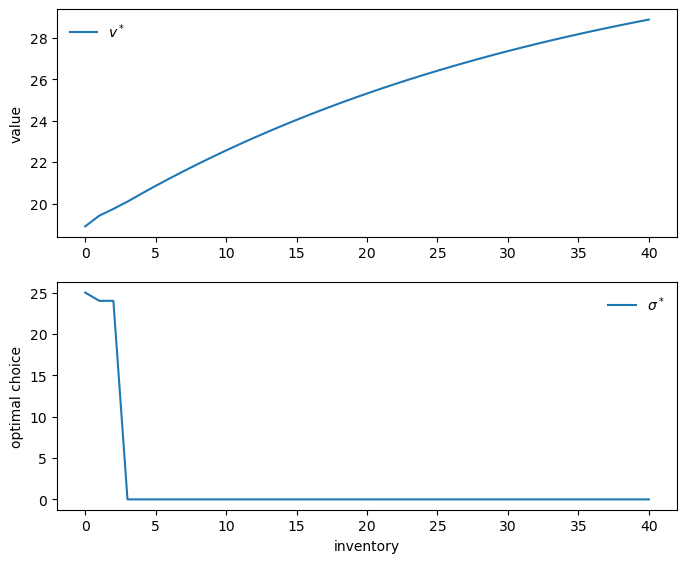

In [12]:
# Create an instance of the model and solve it
model = create_inventory_model()
β, K, c, κ, p = model
v_init = np.zeros(K+1)
v_star, σ_star = solve_inventory_model(v_init, model)

# == Plots == #
fig, axes = plt.subplots(2, 1, figsize=(8, 6.5))
ax = axes[0]
ax.plot(np.arange(K+1), v_star, label=r"$v^*$")
ax.set_ylabel("value", fontsize=10)
ax.legend(fontsize=10, frameon=False)

ax = axes[1]
ax.plot(np.arange(K+1), σ_star, label=r"$\sigma^*$")
ax.set_xlabel("inventory", fontsize=10)
ax.set_ylabel("optimal choice", fontsize=10)
ax.legend(fontsize=10, frameon=False)
plt.show()

There is a threshold region below which the firm orders large batches
and above which the firm orders nothing. The firm wishes to economize on the fixed cost of ordering $\kappa = 2$.

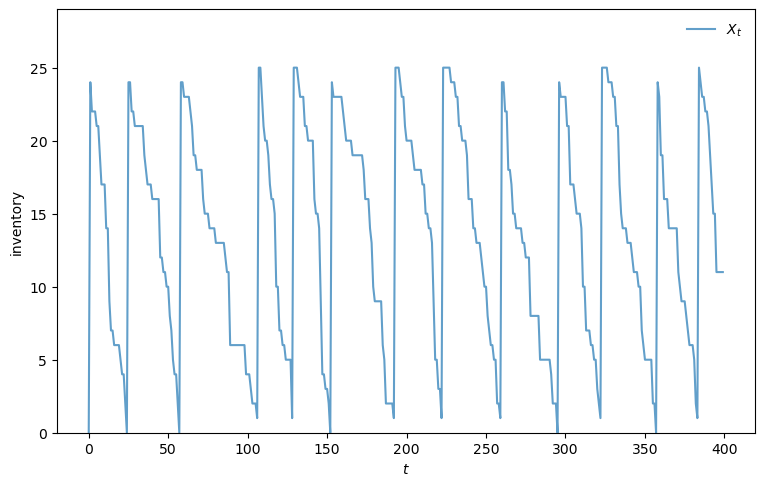

In [5]:
def sim_inventories(ts_length=400, X_init=0):
    """Simulate given the optimal policy."""
    
    global p, σ_star
    X = np.zeros(ts_length, dtype=np.int32)
    X[0] = X_init
    # Subtracts 1 because numpy generates only positive integers
    rand = np.random.default_rng().geometric(p=p, size=ts_length-1) - 1
    for t in range(0, ts_length-1):
        X[t+1] = np.maximum(X[t] - rand[t], 0) + σ_star[X[t] + 1]
    return X

X = sim_inventories()
fig, ax = plt.subplots(figsize=(9, 5.5))
ax.plot(X, label="$X_t$", alpha=0.7)
ax.set_xlabel("$t$", fontsize=10)
ax.set_ylabel("inventory", fontsize=10)
ax.legend(fontsize=10, frameon=False)
ax.set_ylim(0, np.max(X)+4)
plt.show()

# Extension to Decision-Hazard-Decision

Recall that the transition of inventory $x_t$ is

$$ x_{t+1} = (x_t - d_{t+1}) \vee 0 + a_t. $$

It is based on the setting where orders take one period to arrive.


Now consider that the firm has two suppliers.

The bigger one is far away from the firm. The orders $b_t$ from it take one period to arrive.

The smaller one is near the firm. The orders $a_{t+1}$ from it arrive immediately.

The timing of events:

$$ x_t \to \text{ choose } b_t \to d_{t+1} 
\to \text{ choose } a_{t+1} \to x_{t+1} $$

The transition of $x_t$ is

$$ x_{t+1} = (x_t + a_{t+1} - d_{t+1}) \vee 0 + b_t. $$

The current profits are given by

$$ \pi_t = (x_t + a_{t+1}) \wedge d_{t+1} - c_1 b_t - 
\kappa \mathbb{1}\{b_t > 0\} - c_2 a_{t+1} $$

Suppose that $a \in \{0, \cdots, \frac{K}{4}\}$ and $c_1 < c_2 < 1$.

The corresponding Bellman equation is 

$$ w(x) = \max_{0 \leq b \leq K - x}
\left\{
\sum_{d \geq 0} 
\max_{a \in \Gamma(x, b, d)} 
\left[ \pi(x, b, d, a) + \beta w(f(x, b, d, a))
\right] \psi(d)
\right\}, $$

where 

$$ \Gamma(x, b, d) = \begin{cases}
\{0\}, & (d - x) + (K - b) \leq 0 \\
\{, \cdots, [(d - x) + (K - b)] \wedge \frac{K}{4}\}, & (d - x) + (K - b) > 0
\end{cases}.
$$

In [31]:
Model = namedtuple("Model", ("β", "K", "c1", "κ", "c2", "p"))


def create_new_model(β=0.98,      # discount factor
                     K=40,        # maximum inventory
                     c1=0.2, κ=2, c2=0.9,  # cost parameters
                     p=0.6):      # demand parameter
    return Model(β=β, K=K, c1=c1, κ=κ, c2=c2, p=p)

@jit
def gamma(x, b, d, K):
    """
    Compute the feasible 'after' action set Γ(x, b, d).
    """
    delta = (d - x) + (K - b)
    
    if delta <= 0:
        return np.array([0], dtype=np.int32)
    else:
        upper_bound = min(delta, K // 4)
        return np.arange(0, upper_bound + 1, dtype=np.int32)
    

@jit(parallel=True)
def B_inside(x, b, d, w, model):
    """
    Compute maximization over a
    
    max_a [π + β w]
    """
    β, K, c1, κ, c2, p = model
    
    a_set = gamma(x, b, d, K)
    
    values = np.empty(len(a_set))
    for i in prange(len(a_set)):
        a = a_set[i]
        
        reward = np.minimum(x+a, d) - c1 * b - κ *  (b > 0) - c2 * a
        new_x = np.maximum(x+a-d, 0) + b
        values[i] = reward + β * w[new_x]
        
    return np.max(values)


@jit
def B_new(x, b, w, model, d_max=101):
    """
    The function
    B(x, b, w) = Σ_d B_inside ψ(d).
    """
    β, K, c1, κ, c2, p = model
    
    x1 = np.array([B_inside(x, b, d, w, model) * demand_pdf(d, p)
                  for d in np.arange(d_max)])
    
    return np.sum(x1)


@jit(parallel=True)
def T_new(w, model):
    """
    The Bellman operator.
    """
    β, K, c1, κ, c2, p = model
    
    new_w = np.empty_like(w)
    for x in prange(0, K+1):
        x1 = np.array([B_new(x, b, w, model)
                      for b in np.arange(K-x+1)])
        new_w[x] = np.max(x1)
        
    return new_w


@jit
def get_new_greedy(w, model):
    """
    Get a w-greedy policy.  Returns a zero-based array.
    """
    β, K, c1, κ, c2, p = model
    
    σ_star = np.zeros(K+1, dtype=np.int32)
    for x in range(0, K+1):
        x1 = np.array([B_new(x, b, w, model) for b in np.arange(K-x+1)])
        σ_star[x] = np.argmax(x1)
    return σ_star


def solve_new_model(w_init, model):
    """
    Use successive_approx to get w_star.
    """
    β, K, c1, κ, c2, p = model
    
    w_star = compute_fixed_point(lambda w: T_new(w, model), w_init,
                                 error_tol=1e-5, max_iter=1000, 
                                 print_skip=25)
    
    σ_star = get_new_greedy(w_star, model)
    return w_star, σ_star



In [32]:
model = create_new_model(c2=0.5)
β, K, c1, κ, c2, p = model
w_init = np.zeros(K+1)

In [ ]:
%%time


w_star, b_star = solve_new_model(w_init, model)


Iteration    Distance       Elapsed (seconds)
---------------------------------------------


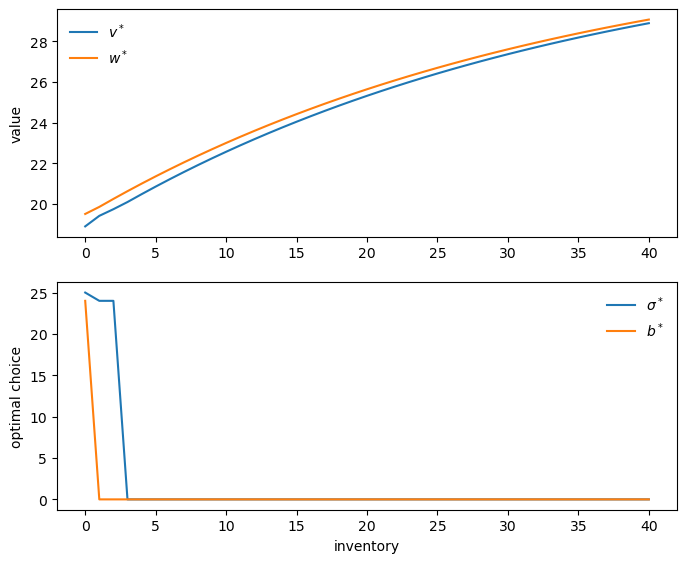

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6.5))
ax = axes[0]
ax.plot(np.arange(K+1), v_star, label=r"$v^*$")
ax.plot(np.arange(K+1), w_star, label=r"$w^*$")
ax.set_ylabel("value", fontsize=10)
ax.legend(fontsize=10, frameon=False)

ax = axes[1]
ax.plot(np.arange(K+1), σ_star, label=r"$\sigma^*$")
ax.plot(np.arange(K+1), b_star, label=r"$b^*$")
ax.set_xlabel("inventory", fontsize=10)
ax.set_ylabel("optimal choice", fontsize=10)
ax.legend(fontsize=10, frameon=False)
plt.show()